In [1]:
#Packages 

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Fixed input values

v = 1*10**(-6) #kinematic viscosity
rho = 1000
g = 9.81
x = 2 #number of screws
eta_0 = 0.7
eta_r = 0.98
eta_t = 0.98
eta_g = 0.96

In [3]:
#Fixed input values, ship related

L = 135 
B = 11.75 
T = 2.75
C_B = 0.922218379546862
P_installed = 1267 #kW
C_BB = 0.185

c_stern = 0
one_k2 = 1.5 #appendage resistance factor

In [4]:
#Ship related values, calculated from fixed input values

C_M = 1.006 - 0.0056 * C_B **(-3.56)
C_wp = (1+2 * C_B)/3
C_p = C_B / C_M

delta = C_B * L * B * T #water displacement

lcb = -13.5 + 19.4 * C_p
L_R = L * (1 - C_p + (0.06 * C_p * lcb)/(4 * C_p -1))

A_BT = C_BB * B * T * C_M
A_T = 0.1 * B * T

S_T = L*(2*T + B) * np.sqrt(C_M) * (0.453 + 0.4425 * C_B - 0.2862* C_M - 0.003467 * (B/T) + 0.3696 * C_wp) + 2.38 * (A_BT / C_B)
S_APP = 0.05 * S_T
S_B = L * B

D_s = 0.7 * T

In [5]:
#Variables
#V_0 = np.linspace(2.5, 5.0, 101)
V_0 = 4.5
h = np.linspace(3.0, 15.0, 101)
#h = 10

In [6]:
#Section 2.2 Resistance

#Section 2.2.1 Frictional resistance

R_e = V_0 * L / v
D = h - T #distance from bottom ship to the bottom of the fairway

Cf_0 = 0.075 / ((np.log10(R_e)-2)**2)
Cf_proposed = (0.08169/((np.log10(R_e) - 1.717)**2)) * (1 + (0.003998/(np.log10(R_e) - 4.393)) * (D/L)**(-1.083))

a = 0.042612 * np.log10(R_e) + 0.56725
Cf_katsui = 0.0066577 / ((np.log10(R_e) - 4.3762)**a)

V_B = 0.4277 * V_0 * np.exp((h / T)**(-0.07625))

C_f = Cf_0 + (Cf_proposed - Cf_katsui) * (S_B / S_T) * (V_B / V_0)**2

R_f = (C_f * 0.5 * rho * (V_0**2) * S_T) / 1000 #kN

In [7]:
#Section 2.2.2 Viscous resistance

c_14 = 1 + 0.0011 * c_stern
one_k1 = 0.93+0.487 * c_14 * ((B/L)**1.068) * ((T/L)**0.461) * ((L/L_R)**0.122) * (((L**3)/delta)**0.365) * ((1 - C_p)**(-0.604))

In [8]:
#Section 2.2.3 Appendage resistance

R_APP = (0.5 * rho * (V_0**2) * S_APP * one_k1 * C_f) / 1000 #kN

In [9]:
#Section 2.2.4 Wave resistance

F_n = V_0 / np.sqrt(g*L) #Froude number

#coefficient c_7
if B/L < 0.11:
    c_7 = 0.229577 * (B/L)**0.33333
elif B/L > 0.25:
    c_7 = 0.5 - 0.0625 * (L/B)
else:
    c_7 = B/L
            
i_E = 125.67 * (B/L) - 162.25 * (C_p ** 2) + 234.32 * (C_p ** 3) + 0.155087 * (lcb ** 3)
c_1 = 2223105 * (c_7 ** 3.78613) * ((T/B)**1.07961) * ((90 - i_E)**(-1.37565))

c_3 = 0.56 * (A_BT ** 1.5) / (B * T * (0.31 * np.sqrt(A_BT) + T - 0.5*T))
c_2 = np.exp(-1.89 * np.sqrt(c_3))
c_5 = 1 - 0.8 * A_T / (B * T * C_M)

#coefficient c_16
if C_p < 0.80:
    c_16 = 8.07981 * C_p - (13.8673 * C_p ** 2) + (6.984388 * C_p ** 3)
else:
    c_16 = 1.73014 - 0.7067 * C_p

m_1 = 0.0140407 * (L/T) - (1.75254 * delta**(1/3))/L - 4.79323 * (B/L) - c_16

#coefficient c_15
if (L**3)/delta < 512:
    c_15 = -1.69385
elif (L**3)/delta > 1727:
    c_15 = 0
else:
    c_15 = -1.69385 + (L / (delta**(1/3)) - 8.0) / 2.36

m_2 = c_15 * (C_p**2) * np.exp(-0.1 * (F_n)**(-2))

#coefficient lambda
if L/B < 12:
    lmbda = 1.446 * C_p - 0.03 * (L/B)
else:
    lmbda = 1.446 * C_p - 0.36
    

R_W = (c_1 * c_2 * c_5 * delta * rho * g * np.exp(m_1 * (F_n**-0.9) + m_2 * np.cos(lmbda * (F_n**(-2))))) / 1000 #kN

In [10]:
#Section 2.2.5 Residual resistance terms

#Resistance resulting from the bulbouw bow
P_B = 0.56 * np.sqrt(A_BT) / (T - 1.5 * 0.5*T)
F_ni = V_0 / np.sqrt(g * (T - 0.5*T - 0.25*np.sqrt(A_BT)) + 0.15*(V_0**2))


R_B = (0.11 * np.exp(-3 * P_B**(-2)) * (F_ni**3) * (A_BT**1.5) * rho * g / (1 + (F_ni**2))) / 1000 #kN


#Resistance due to immersed transom
F_nt = V_0 / np.sqrt(2 * g * A_T / (B + B * C_wp))


if F_nt < 5:
    c_6 = 0.2 * (1 - 0.2 * F_nt)
else:
    c_6 = 0
    
R_TR = (0.5 * rho * (V_0**2) * A_T * c_6) / 1000 #kN


#Model-ship correlation resistance
if T/L > 0.04:
    c_4 = 0.04
else:
    c_4 = T / L
    
C_A = 0.006 * ((L + 100)**(-0.16)) - 0.00205 + 0.003 * np.sqrt(L/7.5) * (C_B**4) * c_2 * (0.04 - c_4)

R_A = (0.5 * rho * (V_0**2) * S_T * C_A) / 1000 #kW

In [11]:
#Section 2.2 Resistance

#Total resistance

R_tot = R_f * one_k1 + R_APP + R_W + R_B + R_TR + R_A

In [12]:
#Section 2.1 Total required power

#2.1.1 Required power for systems on board
P_hotel = 0.081 * P_installed

#2.1.2 Required power for propulsion

#Effective Horse Power (EHP)
P_EHP = V_B * R_tot


if F_n < 0.2:
    dw = 0
else:
    dw = 0.1
    
w = 0.11 * (0.16 / x) * C_B * np.sqrt((delta**(1/3)) / D_s) - dw

if x == 1:
    t = 0.6 * w * (1 + 0.67 * w)
else:
    t = 0.8 * w * (1 + 0.25 * w)
    
eta_h = (1 - t) / (1 - w)

#Delivered Horse Power (DHP)

P_DHP = P_EHP / (eta_0 * eta_r * eta_h)

#Brake Horse Power (BHP)
P_BHP = P_DHP / (eta_t * eta_g)

P_tot = P_hotel + P_BHP

33.74052913356277


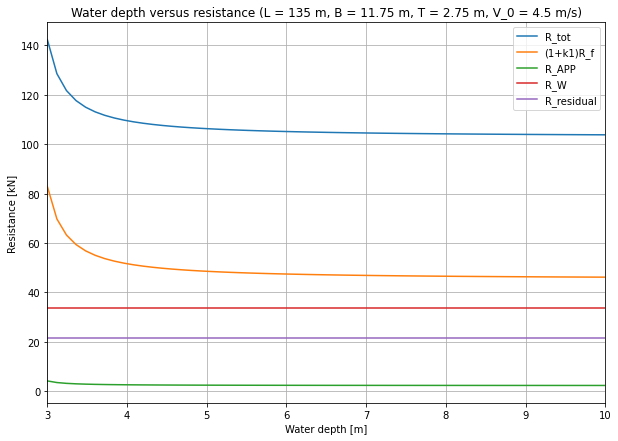

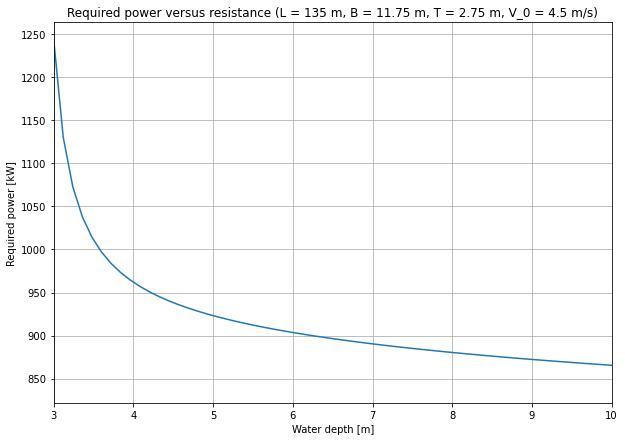

In [13]:
#When h is fixed

#Water depth versus resistance
plt.figure(figsize=(10,7))
plt.plot(h, R_tot)
plt.plot(h, one_k1*R_f)
plt.plot(h, R_APP)

x_coordinates = [3.0, 10.0]
R_W_coordinates = [R_W, R_W]
R_residual_coordinates = [R_B + R_TR + R_A, R_B + R_TR + R_A]

plt.plot(x_coordinates, R_W_coordinates)
plt.plot(x_coordinates, R_residual_coordinates)

plt.grid()
plt.xlim(3.0, 10.0)
plt.legend(['R_tot', '(1+k1)R_f', 'R_APP', 'R_W', 'R_residual'])
plt.xlabel('Water depth [m]')
plt.ylabel('Resistance [kN]')
plt.title('Water depth versus resistance (L = 135 m, B = 11.75 m, T = 2.75 m, V_0 = 4.5 m/s)')

#Water depth versus required power
plt.figure(figsize=(10,7))
plt.plot(h, P_tot)
plt.grid()
plt.xlim(3.0, 10.0)
plt.xlabel('Water depth [m]')
plt.ylabel('Required power [kW]')
plt.title('Required power versus resistance (L = 135 m, B = 11.75 m, T = 2.75 m, V_0 = 4.5 m/s)')

print(R_W)